In [1]:
import gym
import numpy as np
from ddqn_agent import DDQNAgent
from utils import plot_learning_curve
import pandas as pd

from env6 import TradingSPYEnv
import numpy as np
import os

In [17]:
#env = TradingSPYEnv(init_invest=100.0, sma_len=[5,10,15,20,25],train_test_split=0.5)
env = TradingSPYEnv(init_invest=100.0, sma_len=[5,25,50],train_test_split=0.5,mode='test',fee=0.001,train_data_path='BTCUSD=X.csv')
#env = TradingSPYEnv(init_invest=100.0, sma_len=[5,25,50],train_test_split=0.5,mode='train',fee=0.001,train_data_path='BTCUSD=X.csv')
first_test_step = env.current_step

num_states = env.reset(first_test_step).shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))


agent = DDQNAgent(gamma=0.99, epsilon=0.0, lr=0.0005,
                 input_dims=[num_states],
                 n_actions=num_actions, mem_size=50000, eps_min=0.1,
                 batch_size=8192, replace=5000, eps_dec=1e-5,
                 chkpt_dir='btc/', algo='DDQNAgent',
                 env_name='btc',
                 fc1_dims=64, fc2_dims=64)

agent.load_models()
agent.q_eval.eval()
agent.q_next.eval()

#agent = Agent(gamma=0.99, epsilon=0.5, batch_size=8192, n_actions=num_actions, eps_dec=1e-5, eps_end=0.1, 
#              input_dims = [num_states], lr=0.00005, p=0.5,
#              weight_decay=1e-5)

Size of State Space ->  200
Size of Action Space ->  3
... loading checkpoint ...
... loading checkpoint ...


C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DeepQNetwork(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (loss): SmoothL1Loss()
)

In [18]:
scores, eps_history = [], []
max_score = 0.0
#learn_frequency = 4
#learn_count = 0


score = 0.0
done = False
observation = env.reset(first_test_step)
while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    if (observation_ is not None): 
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
    observation = observation_
scores.append(score)
eps_history.append(agent.epsilon)

total_score = np.sum(scores)

print('total_score %.2f' % total_score,
     'epsilon %.2f ' % agent.epsilon,
     'profit_iteration %.2f ' % info['profit_iteration'],
     'iterations %.2f ' % info['iterations'],
     'long_return %.2f ' % info['long_return']
     )


total_score -1.62 epsilon 0.00  profit_iteration 0.00  iterations 236.00  long_return 1.37 


<AxesSubplot:xlabel='Date'>

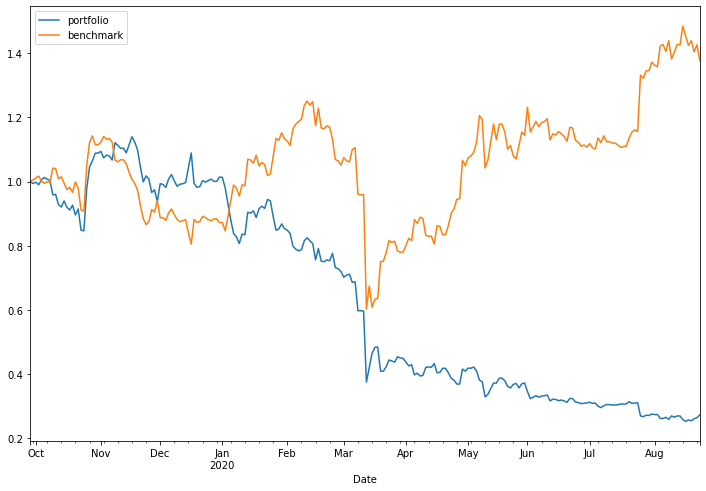

In [19]:
normalized_portfolio = env.features.portfolio_value / 100.0
portfolio = normalized_portfolio[normalized_portfolio > 0.0] 
spy = env.features.Close.loc[portfolio.index]
spy /= spy.iloc[0]
df = {'portfolio': portfolio.values, 'benchmark': spy.values, 'Date': env.features['Date'].loc[portfolio.index]}
df = pd.DataFrame(df)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.plot(figsize=(12,8))

count    238.000000
mean       1.063025
std        0.886025
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: State, dtype: float64


<AxesSubplot:>

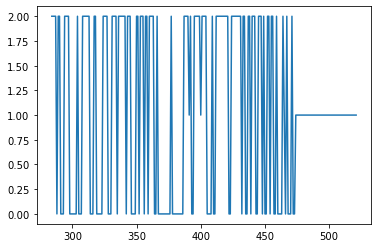

In [20]:
actions = env.features['State'][-df.shape[0]:]
print(actions.describe())
actions.plot()

count    238.000000
mean       0.970588
std        0.462948
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: State, dtype: float64


<AxesSubplot:>

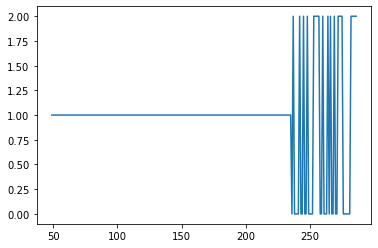

In [21]:
actions = env.features['State'][:df.shape[0]]
print(actions.describe())
actions.plot()